In [1]:
from pathlib import Path
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
from collections import Counter
from sklearn.model_selection import train_test_split
import pandas as pd
import os

In [2]:
def get_all_files(directory, pattern):
    return [f for f in Path(directory).glob(pattern)]

In [3]:
def id2name(id):
    id = id.lower()
    # id = id.rstrip()
    if id == 'metal_non-ferrous':
        return 'non-ferrous metal'
    elif id == 'metal_ferrous':
        return 'ferrous metal'
    elif id == 'metal_ferrous_steel':
        return 'steel'
    elif id == 'metal_aluminum':
        return 'aluminum'
    elif id in ['other', 'wood', 'plastic']:
        return id
    else:
        raise f"Non-default id! {id}"
        # return 'other'

In [5]:
def show_confusion_matrix(y_true, y_pred, classes=None, normalize=None):
    cm = confusion_matrix(y_true, y_pred, normalize=normalize, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(xticks_rotation=45)
    plt.tight_layout()
    plt.show()

In [6]:
# Change this to the directory where you downloaded the dataset
input_dir = r"C:\Users\richt\OneDrive - University of Central Florida\Collabs\Shared OneDrive File - Zack\ASME-Hackathon\data\train_new\Fusion360GalleryDataset_23hackathon_train"
path_felix = r"C:\Users\richt\OneDrive - University of Central Florida\Collabs\Shared OneDrive File - Zack\ASME-Hackathon\data\train_new\Fusion360GalleryDataset_23hackathon_train"     
input_jsons = get_all_files(input_dir, "*/assembly.json")


In [14]:
def unpack_dataset(root_folder = None, exclusion_file_list = {}):
    """
    BFS Implementation of unpacking file directories into a dataset given a root folder.
    ** Assumes first surface level unpacking. Assumes only one Assembly.json
    """
    num = -1 # Excluding Root folder
    master_df = pd.DataFrame();
    queue = []
    
    visited_folders = []
    
    queue.append(root_folder)
    visited_folders.append(root_folder)
    
    while (len(queue) != 0):
        num += 1;
        print("Folders explored: ",num)
        _curr = queue.pop(0)
        if (os.path.isdir(_curr)):
            os.chdir(_curr);
            neighbors = sorted(os.listdir());
            
            for n in neighbors:
                if (n not in exclusion_file_list):
                    path = _curr + "/" + n;
                    if (path not in visited_folders and os.path.isdir(path)):
                        visited_folders.append(path);
                        queue.append(path);
                    else:
                        if ("assembly.json" in path):
                             visited_folders.append(path);
                             queue.append(path);
        else:
            if ("assembly.json" in _curr):
                file = open(_curr)
                json_data = json.load(file)
                _data = list(json_data["bodies"].values())
                df = pd.DataFrame.from_dict(_data)
                master_df = pd.concat([master_df, df], ignore_index=True)
            
    print("Folders Explored:", num)
    
    return master_df

# Annoying, but you have to give the absolute path
df = unpack_dataset(
    path_felix,
    {'.DS_Store'}
) 

Folders explored:  0
Folders explored:  1
Folders explored:  2
Folders explored:  3
Folders explored:  4
Folders explored:  5
Folders explored:  6
Folders explored:  7
Folders explored:  8
Folders explored:  9
Folders explored:  10
Folders explored:  11
Folders explored:  12
Folders explored:  13
Folders explored:  14
Folders explored:  15
Folders explored:  16
Folders explored:  17
Folders explored:  18
Folders explored:  19
Folders explored:  20
Folders explored:  21
Folders explored:  22
Folders explored:  23
Folders explored:  24
Folders explored:  25
Folders explored:  26
Folders explored:  27
Folders explored:  28
Folders explored:  29
Folders explored:  30
Folders explored:  31
Folders explored:  32
Folders explored:  33
Folders explored:  34
Folders explored:  35
Folders explored:  36
Folders explored:  37
Folders explored:  38
Folders explored:  39
Folders explored:  40
Folders explored:  41
Folders explored:  42
Folders explored:  43
Folders explored:  44
Folders explored:  4

In [15]:
print(df.size)
df.head

1049984


<bound method NDFrame.head of          name      type                                       png  \
0       Body1  BRepBody  f130d4f0-054c-11ec-a094-0a2b8709b52f.png   
1       Body4  BRepBody  f1314a74-054c-11ec-ac03-0a2b8709b52f.png   
2       Body5  BRepBody  f131bfb6-054c-11ec-9eb4-0a2b8709b52f.png   
3       Body6  BRepBody  f13234e8-054c-11ec-8b13-0a2b8709b52f.png   
4       Body7  BRepBody  f13282ee-054c-11ec-aa03-0a2b8709b52f.png   
...       ...       ...                                       ...   
131243  Body1  BRepBody  f95a09b6-0613-11ec-b131-0226f5980261.png   
131244  Body1  BRepBody  f95a5828-0613-11ec-ab9b-0226f5980261.png   
131245  Body2  BRepBody  f95a7efe-0613-11ec-bc18-0226f5980261.png   
131246  Body1  BRepBody  f95acd26-0613-11ec-a896-0226f5980261.png   
131247  Body2  BRepBody  f95af41c-0613-11ec-8208-0226f5980261.png   

                                             smt  \
0       f130d4f0-054c-11ec-a094-0a2b8709b52f.smt   
1       f1314a74-054c-11ec-ac03-0a2b8

In [9]:
# ... [Your other imports and functions]

assemblies = {}
for input_json in tqdm(input_jsons):
    with open(input_json, "r", encoding="utf-8") as f:
        assembly_data = json.load(f)

    # Extract densities from occurrences
    densities = {}
    if "occurrences" in assembly_data:
        for occ_key, occurrence in assembly_data["occurrences"].items():
            physical_properties = occurrence.get("physical_properties")
            if physical_properties:
                density = physical_properties.get("density")
                if density and "bodies" in occurrence:  # Check for "bodies" key before accessing it
                    for body_key in occurrence["bodies"]:
                        densities[body_key] = density

    bodies = []
    for key, value in assembly_data['bodies'].items():
        name = value['name']
        material = value['material_category']

        # Only consider bodies with custom names
        if name[:4] != 'Body':
            body_data = {'name': name, 'material': material}
            # If density data exists for the body, include it
            body_data['density'] = densities.get(key, float('nan'))
            bodies.append(body_data)

    if len(bodies) > 0:
        assemblies[input_json.parts[-2]] = bodies

# ... [Rest of your code]


100%|██████████| 6336/6336 [00:13<00:00, 469.02it/s]


In [10]:
print(f"Number of total assemblies in the training set: {len(input_jsons)}")
print(f"Number of assemblies that have at least one non-default part name: {len(assemblies)}")

Number of total assemblies in the training set: 6336
Number of assemblies that have at least one non-default part name: 1165


In [11]:
body_list = [assembly_data for assembly_data in assemblies.values()]

train_assemblies, validation_assemblies = train_test_split(body_list, test_size=0.2, shuffle=True, random_state=0)

In [12]:
print(f"number of train assemblies: {len(train_assemblies)}")
print(f"number of validation assemblies: {len(validation_assemblies)}")

number of train assemblies: 932
number of validation assemblies: 233


Accuracy: 0.4079942383867483


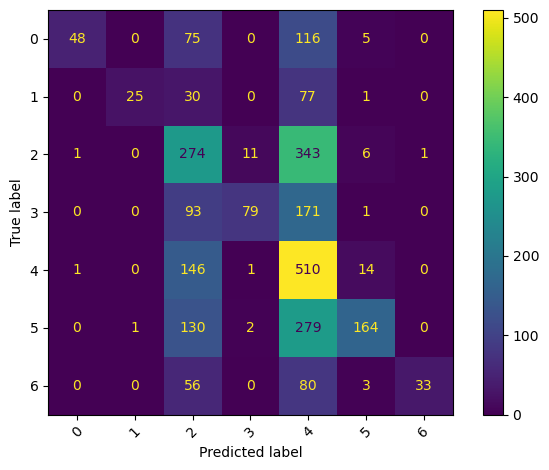

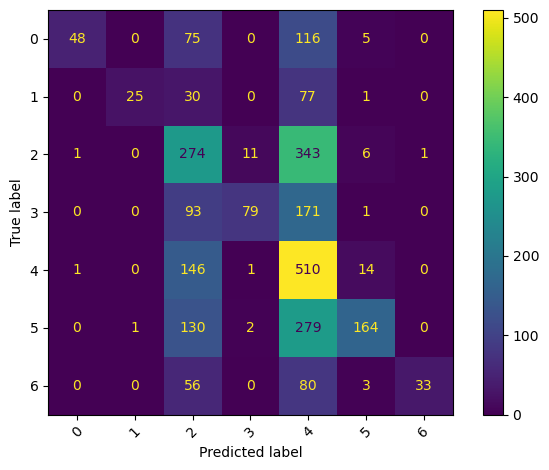

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Extract densities and material categories from the 'assemblies' dictionary
densities = []
materials = []

for assembly in assemblies.values():
    for body in assembly:
        densities.append(body['density'])
        materials.append(body['material'])

# Convert lists to numpy arrays
import numpy as np
densities = np.array(densities).reshape(-1, 1)  # Reshape to a 2D array
materials = np.array(materials)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(densities, materials, test_size=0.2, random_state=0)

from sklearn.impute import SimpleImputer

# Use the mean value of the training data to replace NaNs
imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Then train the model using the imputed data
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train_imputed, y_train)
y_pred = clf.predict(X_test_imputed)

# Print accuracy and confusion matrix
print("Accuracy:", accuracy_score(y_test, y_pred))
show_confusion_matrix(y_test, y_pred)

# Show confusion matrix
show_confusion_matrix(y_test, y_pred)
